In [1]:
%load_ext autoreload
%autoreload 2

import keras
import tensorflow_probability as tfp

import scipy
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import os
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')

from plotting_funcs import sample_and_plot

2024-06-10 13:03:03.831645: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 13:03:03.891383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 13:03:03.891419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 13:03:03.892499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 13:03:03.900403: I tensorflow/core/platform/cpu_feature_guar

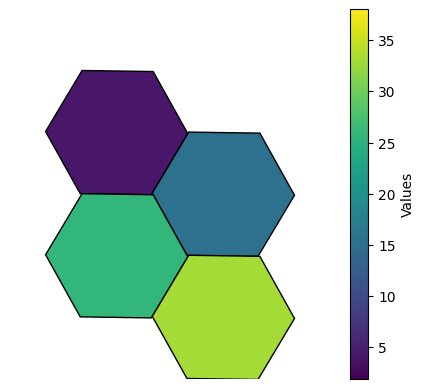

In [2]:
# Distribution Settings
scale = 1
means = [5, 15, 25, 35]

normal_4 = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]
sample_and_plot(normal_4)


S = 4
T= 10000

In [3]:
seed=360
rng = np.random.RandomState(seed)
samples = [dist.rvs(size=T, random_state=rng) for dist in normal_4]
y_TS = np.array(samples).T
assert(y_TS.shape == (T, S))

# empty input
x_TF = np.zeros(shape=(T,0))

2024-06-10 13:03:42.778027: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-10 13:03:42.778064: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-10 13:03:42.778071: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-10 13:03:42.778190: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-10 13:03:42.778219: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-10 13:03:42.778224: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


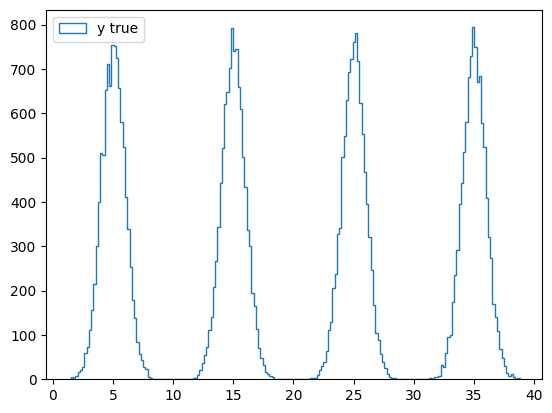

In [4]:
plt.hist(tf.reshape(y_TS, [-1]).numpy(), bins=200,histtype='step', label='y true')
plt.legend()

In [5]:
inputs = keras.Input(shape=0)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [6]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [7]:

model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(0, 4), (4,)]


In [8]:
biases = model.trainable_variables[1]
biases.assign(means)

print(f'Biases {model.get_weights()[1]}')

Biases [ 5. 15. 25. 35.]


In [9]:
M_score = 1000
M_action = 1000

In [10]:
def score_function_trick(jacobian_MTSp, actions_MTS):
    """Implement score function trick
    
    Args:
    jacobian_MTSp: Gradient of the log probability of the samples of y given model parameter p
        tf.Tensor of shape (M, T, S, p), where p is the shape of the parameter
    actions_MTS: Action taken at each sampple
    """
    # Solve for the rank of the parameter by subtracting the sample/time/location dimension
    rank_P = tf.rank(jacobian_MTSp)-3
    # add new size 1 dimensions so that the action broadcasts to the shape of the parameter
    new_shape = tf.concat([tf.shape(actions_MTS), tf.ones([rank_P], tf.int32)], axis=0)
    actions_MTSp = tf.reshape(actions_MTS, new_shape)

    scaled_jacobian_MTSp = jacobian_MTSp*actions_MTSp

    # average over sample dims
    param_gradient_BSp = tf.reduce_mean(scaled_jacobian_MTSp, axis=0)

    return param_gradient_BSp

def overall_gradient_calculation(gradient_TSp, action_gradient_TS):
    """Calculate final loss gradeint
    
    Args:
    gradient_BSp: Of the action w.r.t to parameter p
        tf.Tensor of shape (M, T, S, p), where p is the shape of the parameter
    action_gradient_TS: Gradient of loss w.r.t. to action
    """
    # Solve for the rank of the parameter by subtracting the time/location dimension
    rank_P = tf.rank(gradient_TSp)-2
    # add new size 1 dimensions so that the action broadcasts to the shape of the parameter
    new_shape = tf.concat([tf.shape(action_gradient_TS), tf.ones([rank_P], tf.int32)], axis=0)
    action_gradient_TSp = tf.reshape(action_gradient_TS, new_shape)

    overall_gradient_TSp = gradient_TSp*action_gradient_TSp

    # Sum over spatial dimensions
    overall_gradient_Tp = tf.reduce_sum(overall_gradient_TSp, axis=1)
    # average over time
    overall_gradient_p = tf.reduce_mean(overall_gradient_Tp, axis=0)

    return overall_gradient_p

In [11]:
M_score = 2
M_action = 2
with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
    model_distributions = model(x_TF)
    sample_y_MTS_score = model_distributions.sample(M_score)
    sample_y_MTS_action = model_distributions.sample(M_action)

    # maybe stop?
    sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS_score)
    
    sample_actions_MTS = tf.identity(sample_y_MTS_action)
    expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
    loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
    loss = tf.reduce_mean(loss_T)

# The lowercase p indicates that this is a list of model parameters, each shape MTS+parameter shape
jacobian_pMTS = jacobian_tape.jacobian(sample_log_probs_MTS, model.trainable_weights)
param_gradient_pTS = [score_function_trick(j, sample_actions_MTS) for j in jacobian_pMTS]
        
loss_gradients_TS = loss_tape.gradient(loss_T, expected_actions_TS)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_TS) for g in param_gradient_pTS]

master_gradient = master_tape.gradient(loss_T, model.trainable_weights)

In [ ]:
jacobian_pMTS[0].shape

TensorShape([0, 4])

In [ ]:
jacobian_pMTS[1].shape

TensorShape([4])